# Подсчёт необходимого бюджета для достижения экономических показателей регионов РК

В этом блокноте мы тренируем модель [MLP](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression) для регрессионной задачи.

Для входящих инпутов мы выбрали два экономических параметра региона, на которые влияет объем трансфертов:
- [ВРП](https://ru.wikipedia.org/wiki/%D0%92%D0%B0%D0%BB%D0%BE%D0%B2%D0%BE%D0%B9_%D1%80%D0%B5%D0%B3%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%82)
- Налоговые поступления в регион

## Сбор данных

Для сбора данных мы использовали открытые источники [Министерства Финансов Республики Казахстан](https://www.gov.kz/memleket/entities/minfin?lang=ru) и [Бюро национальной статистики Агентства по стратегическому планированию и реформам Республики Казахстан](https://stat.gov.kz).

Из статистических бюллетеней МФ РК мы взяли **поступления трансфертов** и **налоговых поступлений**, из ИФО мы взяли ВРП регионов за период с 2008 по 2021 года.

Таблица с данными находится в файле `data.csv`

Импортируем данные из csv в DataFrame при помощи модуля [pandas](https://pandas.pydata.org/), после чего сортируем их по выбранному региону

In [1299]:
import pandas as pd

df = pd.read_csv('data.csv', delimiter=";", parse_dates=['year'], decimal=',')
df = df.iloc[::-1]

# Регион можно менять
chosen_region = "Акмолинская область"

df = df[df['region'] == chosen_region]

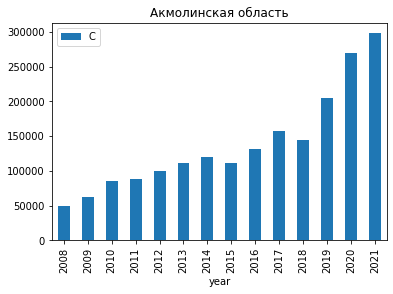

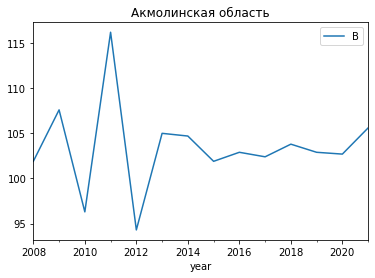

In [1300]:
plt1 = df.plot(x='year', y='sum_mil_tenge', kind='bar', title=chosen_region)
plt1.set_xticklabels(map(lambda label: label.year, df['year']))
plt1.legend("Сумма трансфертов (млн тенге)")

plt2 = df.plot(x='year', y='grp', kind='line', label="ВРП", title=chosen_region)
plt2.legend("ВРП")

Форматируем переменные в формат подходящий для тренировки модели

In [1301]:
import numpy as np

X = df.iloc[:, [3, 4]].values
X = X.astype('float32')
y = df.iloc[:, 2].values

print(X, y)

[[1.0190e+02 1.9842e+04]
 [1.0760e+02 2.1076e+04]
 [9.6300e+01 2.2996e+04]
 [1.1620e+02 2.8533e+04]
 [9.4300e+01 3.3553e+04]
 [1.0500e+02 3.6457e+04]
 [1.0470e+02 4.2124e+04]
 [1.0190e+02 4.5953e+04]
 [1.0290e+02 5.2553e+04]
 [1.0240e+02 5.6933e+04]
 [1.0380e+02 6.3807e+04]
 [1.0290e+02 6.5568e+04]
 [1.0270e+02 8.1405e+04]
 [1.0560e+02 9.7341e+04]] [ 49652  62107  84893  88298 100234 111976 119819 110757 131221 157966
 143988 204668 269574 298031]


Для тренировки, мы разбиваем наборы данных на тренировочные и тестовые:
- 80 процентов данных будут использоваться для тренировки
- 20 процентов данных будут использоваться для тестирования

In [1302]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Наша задача состоит в предсказании числового значения в определенном промежутке, что попадает под категорию [регресии](https://ru.wikipedia.org/wiki/%D0%A0%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_(%D0%BC%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D0%BA%D0%B0))

В качестве модели мы используем [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor), так как он показал наибольшую точность по сравнению с:
- LinearRegression
- SVR
- SGDRegressor
- KNeighborsRegressor
- BayesianRidge
- TheilSenRegressor

Архитетура нейронной сети будет состоять из:
- 2 входящих нейронов
- 100 скрытых нейронов
- 1 выходного нейрона

Так как данных не настолько много, мы используем функцию активации [tanh](https://en.wikipedia.org/wiki/Hyperbolic_functions#Hyperbolic_tangent) и алгоритм обучения [lbfgs](https://en.wikipedia.org/wiki/Limited-memory_BFGS)

In [1303]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

regressor = make_pipeline(
    StandardScaler(),
    MLPRegressor(
        random_state=1,
        max_iter=1000000,
        max_fun=100000,
        activation="tanh",
        solver="lbfgs",
        tol=1e-5,
    )
)
regressor.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='tanh', max_fun=100000,
                              max_iter=1000000, random_state=1, solver='lbfgs',
                              tol=1e-05))])

In [1304]:
y_pred = regressor.predict(X_test)

Подсчитываем точность модели в величину ошибок:
- Среднюю абсолютную ошибку [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error)
- Среднюю абсолютную ошибку в процентах[MAPE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html#sklearn.metrics.mean_absolute_percentage_error)
- Максимальная ошибка [Max Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.max_error.html#sklearn.metrics.max_error)

In [1305]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:', metrics.max_error(y_test, y_pred))

Mean Absolute Error: 12653.560103486976
Mean Absolute Percentage Error: 0.10561440451176662
Max Error: 20185.08705056543


Подготоваливаем графики для показа предсказаний за года с 2008 по 2021

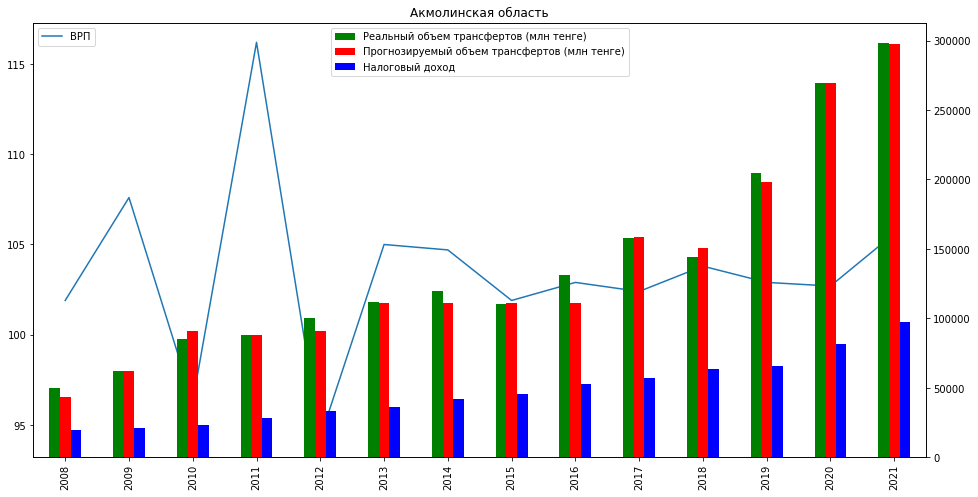

In [1306]:
result_df = pd.DataFrame()

result_df['Year'] = df['year']
result_df['Tax_Income'] = df['tax_income']
result_df['Actual_Budget'] = y
result_df['Pred_Budget'] = regressor.predict(X)
result_df['GRP'] = df['grp']
result_df.set_index('Year', inplace=True)

ax = result_df[['GRP']].plot(figsize=(16, 8), title=chosen_region, use_index=False)
ax2 = result_df[['Actual_Budget', 'Pred_Budget', 'Tax_Income']].plot(ax=ax, kind="bar", secondary_y=True,
                                                                     use_index=False,
                                                                     color=['green', 'red', 'blue'])
x_labels = result_df.index.strftime('%Y')
ax.set_xticklabels(x_labels)

ax.legend(['ВРП'], loc="upper left")
ax2.legend(
    ['Реальный объем трансфертов (млн тенге)', 'Прогнозируемый объем трансфертов (млн тенге)', 'Налоговый доход'],
    loc="upper center")

Для проверки модели на реальных данных мы взяли информацию за 2021 по Акмолинской области.

Текущие показатели (2022 март):
- Сумма трансфертов 32 959 млн тенге
- ВРП 103.3 процента
- Налоговые перечисления 18 062 млн тенге

Модель показывает, что при данных показателях ВРП и доходов, региону требовалось только 14 569 млн тенге, что составляет только 45% от реально перечисленных средств.

[14569.01009632]


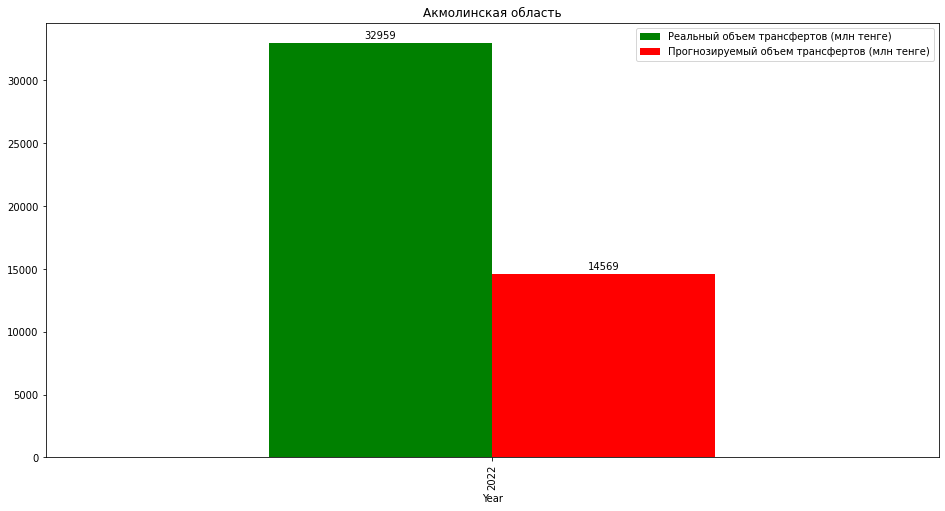

In [1307]:
result_test_df = pd.DataFrame()

Pred_Budget = regressor.predict([[103.3, 18062]])

result_test_df['Year'] = [2022]
result_test_df['Actual_Budget'] = [32959]
result_test_df['Pred_Budget'] = Pred_Budget
result_test_df.set_index('Year', inplace=True)

print(Pred_Budget)

ax1 = result_test_df[['Actual_Budget', 'Pred_Budget']].plot(kind="bar", color=['green', 'red'], figsize=(16, 8),
                                                            title=chosen_region)
ax1.legend(['Реальный объем трансфертов (млн тенге)', 'Прогнозируемый объем трансфертов (млн тенге)'],
           loc="upper right")

for container in ax1.containers:
    ax1.bar_label(container, padding=3)

Сохраняем модель для дальнейшего использования

In [1308]:
from joblib import dump

dump(regressor, 'models/mlp-akmolinskaya-obl.joblib')

['models/mlp-akmolinskaya-obl.joblib']